In [74]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/tabular-playground-series-nov-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-nov-2021/train.csv
/kaggle/input/tabular-playground-series-nov-2021/test.csv


In [75]:
import os
import wandb
from wandb.keras import WandbCallback
os.system('! wandb login be213aaff4ff14945d480abc18697d8664bba8c8')
training = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/test.csv')
test['target'] = np.NaN
training['train_test'] = 1
test['train_test'] = 0
all_data = pd.concat([training,test]) 

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
attribute_names = all_data.columns.tolist()
test_atts = test.columns.tolist()
all_dummies = pd.get_dummies(all_data[attribute_names])
test_dummies = pd.get_dummies(test[test_atts])  
X_train = all_dummies[all_data.train_test == 1].drop(['train_test'], axis=1)
for column in X_train.columns:
    mean_value = X_train[column].mean()
    X_train[column].fillna(mean_value, inplace=True)
X_check = X_train #for heatmap
X_train = X_train.drop(['target'], axis=1)
X_backup = X_train
X_test = all_dummies[all_data.train_test == 0].drop(['train_test'], axis=1)
y_train = all_data[all_data.train_test==1].target
y_backup = y_train
X_test = X_test.drop(['target'], axis=1)
for column in X_test.columns:
    mean_value = X_test[column].mean()
    X_test[column].fillna(mean_value, inplace=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [76]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_adapt = X_train.drop(['id'], axis=1)
all_attributes =X_adapt.columns.tolist()
columns_to_normalize = all_attributes
scaler = MinMaxScaler()
X_train_scaled = X_train
X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
#X_train_scaled = X_train_scaled[:,~np.all(np.isnan(d), axis=0)]
X_test_scaled = X_test
X_test_scaled[columns_to_normalize] = scaler.fit_transform(X_test[columns_to_normalize])

#also norm. backup
X_backup[columns_to_normalize] = scaler.fit_transform(X_backup[columns_to_normalize])

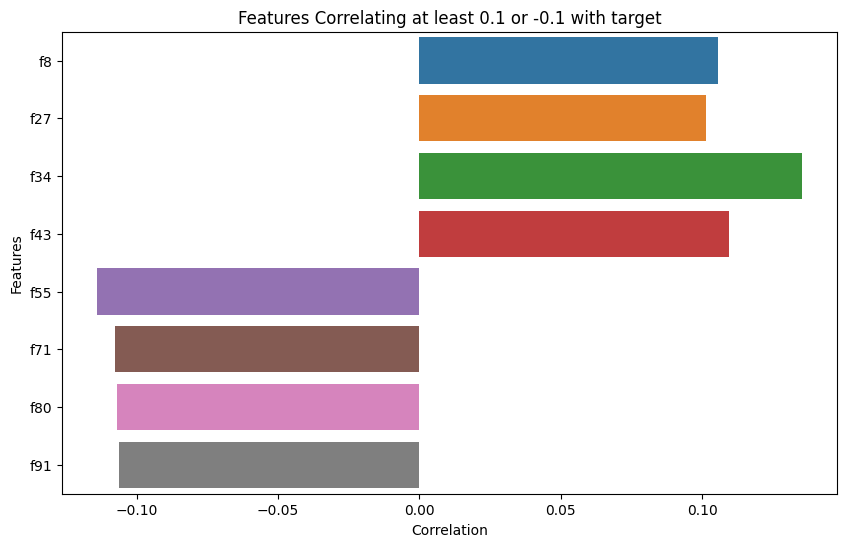

              f8       f27       f34       f43       f55       f71       f80  \
0       0.437860  0.383577  0.668653  0.304328  0.363233  0.677683  0.868182   
1       0.758411  0.347932  0.226292  0.584990  0.262885  0.559769  0.637855   
2       0.398849  0.398059  0.125291  0.110332  0.107788  0.266347  0.662589   
3       0.752827  0.372626  0.689068  0.253950  0.175985  0.584210  0.692141   
4       0.604515  0.376516  0.607420  0.515707  0.143854  0.451374  0.232362   
...          ...       ...       ...       ...       ...       ...       ...   
599995  0.360000  0.376446  0.148985  0.804967  0.102722  0.472427  0.295838   
599996  0.277418  0.388653  0.456161  0.120167  0.632949  0.779991  0.724463   
599997  0.300987  0.375381  0.318810  0.400547  0.652430  0.640074  0.426788   
599998  0.421029  0.397159  0.279071  0.404634  0.286598  0.424765  0.199129   
599999  0.318868  0.391909  0.788113  0.398251  0.333194  0.876951  0.187571   

             f91  
0       0.297285  
1

In [77]:
target_column = 'target'

# Calculate the correlations between the target and all features
correlations = training.corr()[target_column]
correlations = correlations.drop('target')
# Filter features with a correlation of at least 0.4 or -0.4
significant_features = correlations[(correlations >= 0.1) | (correlations <= -0.1)]
significant_features_index = correlations[(correlations >= 0.1) | (correlations <= -0.1)].index

# Visualize the correlation values
plt.figure(figsize=(10, 6))
sns.barplot(x=significant_features.values, y=significant_features.index)
plt.title(f'Features Correlating at least 0.1 or -0.1 with {target_column}')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()
X_train_sig = X_train_scaled[significant_features_index]
print(X_train_sig)

In [78]:
from sklearn.model_selection import train_test_split

'''# Split the data into training and temporary backup sets
X_train_temp, X_backup, y_train_sig, y_backup = train_test_split(X_train_sig, y_train, test_size=0.2, random_state=1)

# Split the backup set into a new validation set
X_val, X_backup, y_val, y_backup = train_test_split(X_train, y_train, test_size=0.07, random_state=1)

# Ensure that the indices are reset for each subset
X_train_sig = X_train_temp.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_backup = X_backup.reset_index(drop=True)
y_train = y_train_sig.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_backup = y_backup.reset_index(drop=True)

num_samples = int(len(X_train) * 0.01)
random_indices = np.random.choice(len(X_train), num_samples, replace=False)
#X_subset = X_train_sig.iloc[random_indices]
#y_subset = y_train.iloc[random_indices]
X_subset = X_backup.iloc[random_indices]
y_subset = y_backup.iloc[random_indices]

X_val = X_val.iloc[random_indices]
y_val = y_val.iloc[random_indices]'''

'# Split the data into training and temporary backup sets\nX_train_temp, X_backup, y_train_sig, y_backup = train_test_split(X_train_sig, y_train, test_size=0.2, random_state=1)\n\n# Split the backup set into a new validation set\nX_val, X_backup, y_val, y_backup = train_test_split(X_train, y_train, test_size=0.07, random_state=1)\n\n# Ensure that the indices are reset for each subset\nX_train_sig = X_train_temp.reset_index(drop=True)\nX_val = X_val.reset_index(drop=True)\nX_backup = X_backup.reset_index(drop=True)\ny_train = y_train_sig.reset_index(drop=True)\ny_val = y_val.reset_index(drop=True)\ny_backup = y_backup.reset_index(drop=True)\n\nnum_samples = int(len(X_train) * 0.01)\nrandom_indices = np.random.choice(len(X_train), num_samples, replace=False)\n#X_subset = X_train_sig.iloc[random_indices]\n#y_subset = y_train.iloc[random_indices]\nX_subset = X_backup.iloc[random_indices]\ny_subset = y_backup.iloc[random_indices]\n\nX_val = X_val.iloc[random_indices]\ny_val = y_val.iloc[ran

In [79]:
X_train = X_train_sig
#
num_samples = int(len(X_train) * 0.07)
random_indices = np.random.choice(len(X_train), num_samples, replace=False)
X_train = X_train.iloc[random_indices]
y_train = y_train.iloc[random_indices]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [80]:
import datetime

# Get the current date and time
current_time = datetime.datetime.now()

# Convert the current time to a string with a specific format
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Create a string with the formatted time
time = f"{formatted_time}"

In [81]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import wandb
wandb.init(project='KaggleNovemer2021NN', name='new approach with NN'+time)
#X = data.drop('target', axis=1)  # Features
#y = data['target']  # Labels (binary classification)

# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.int64)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.int64)

class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()  # Corrected line
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize the model
input_size = X_train.shape[1]
hidden_size = 64
output_size = 2  # Change this to match your number of classes
model = SimpleClassifier(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # Log the loss and other metrics to WandB
    wandb.log({"train_loss": loss.item()}, step=epoch)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    _, predicted = torch.max(y_pred, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)

wandb.log({"test_accuracy": accuracy})

# Save the model
torch.save(model.state_dict(), "model.pth")

# Finish logging
wandb.finish()

test_accuracy,▁
train_loss,█▇▆▅▄▃▃▂▂▁
test_accuracy,0.54357
train_loss,0.69217


In [ ]:
y_hat_base_vc = nn.predict(X_test_scaled).astype(float)
submission = {'id': test.id , 'target': y_hat_base_vc}
submission = pd.DataFrame(data=submission)
submission.to_csv('submission.csv', index=False)